# **MNIST Convolutional Neural Network (CNN)**

In this notebook we want you to take a step further and implement a convolutional neural network to beat the performance of your mlp classifier. In addition, we will show you how to track the training process with [tensorboard](https://www.tensorflow.org/tensorboard). Finally, you visualize the discriminative power of your CNN with [t-SNE](https://lvdmaaten.github.io/tsne/).

<br>

**Task:**

- Please solve all the tasks with code.
- You are free to use any python package you like, however, the imports should be enough to solve all the tasks.
- Questions (marked with QUESTION tag) requires you to write a short and concise text.

**Note:**
- Keep in mind that there is not only one solution for each task.
- If you need any help use the [Tensorflow Documentation](https://www.tensorflow.org/) or the [Keras Documentation](https://keras.io)

## Prerequisites

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
# Import MNIST data

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

RECAP: Repeat the preprocessing steps from the last exercise!

Note: You also need to reshape the images as the convolutional layers expect a color channel (Width, Height, Channel)!

In [19]:
# Normalize the images and add a color channel
def normalize(image):
    return image.astype(np.float32) / 255.

def addColorChannel(dataset):
    return dataset.reshape(dataset.shape[0], 28, 28, 1)

x_train_normalized = addColorChannel(np.apply_along_axis(normalize, 2, x_train))
x_test_normalized = addColorChannel(np.apply_along_axis(normalize, 2, x_test))


# One-hot encode the labels

y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

Setting up tensorboard.

In [20]:
# Loading the tensorboard extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
# Setting up tensorboard
tensorboard = TensorBoard(
  log_dir='./logs',
  histogram_freq=1
)
keras_callbacks = [
  tensorboard
]

## Learning a CNN


Define an arbitrary CNN!

In [22]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
    tf.keras.layers.Activation(activation="relu"),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation(activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu", name="dense128"),
    tf.keras.layers.Dense(10, name="dense10"),
    tf.keras.layers.Softmax()
])

Define hyperparameters, cost function (loss) and optimizer!

In [23]:
eta = 0.001
optimizer = tf.keras.optimizers.Adam(eta)
loss = tf.keras.losses.CategoricalCrossentropy()
epochs=13

Compile the model and train it on the training set!

Note: Add the `callbacks` argument to the `fit()` method to track your training in tensorboard!

In [24]:
cnn.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.CategoricalAccuracy()])
cnn.fit(x=x_train_normalized, y=y_train_one_hot, epochs=epochs, callbacks=keras_callbacks)

Epoch 1/13
1875/1875 [==============================] - 37s 19ms/step - loss: 0.2622 - categorical_accuracy: 0.9184

Start tensorboard and have a look at the training process!

Note: You can also run tensorboard before the training for live-tracking.

In [25]:
%tensorboard --logdir logs

Launching TensorBoard...

Evaluate the performance of your classifier! It should achieve high accuracy (> 98%) on the test set!

You might adjust the model architecture and/or the hyperparameters if you don't make it above 98% accuracy.

In [26]:
results = cnn.evaluate(x_test_normalized, y_test_one_hot)
print("test loss, test acc: ", results)

313/313 [==============================] - 2s 5ms/step - loss: 0.0677 - categorical_accuracy: 0.9884 

Use the test set and take the outputs of the penultimate fully connected layer (not the logits!) and visualize it with t-SNE!

<br>

Hint: Have a look in the [Keras FAQ Documentation](https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction) to find out how to get intermediate outputs of any layer.

In [27]:
# Make predictions for the test set and convert them back to categorical
predictions = cnn.predict(x_test_normalized)
prediction_categorical_labels = np.array([np.argmax(prediction) for prediction in predictions])


In [30]:
# Build a model for the outputs of the penultimate fully connected layer
intermediate_model = tf.keras.Model(inputs=cnn.inputs, outputs=cnn.get_layer("dense128").output)
intermediate_output = intermediate_model.predict(x_test_normalized)

In [32]:
# Instantiate and fit t-SNE
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(intermediate_output)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 2.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.871622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.396179
[t-SNE] KL divergence after 1000 iterations: 1.475672


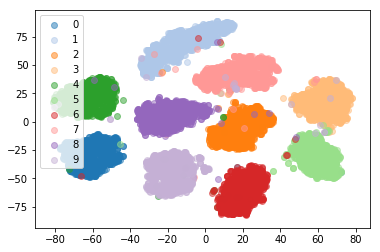

In [34]:
# Plot t-SNE projections
cmap = cm.get_cmap('tab20')
n_classes = 10
for label in range(n_classes):
    idx = prediction_categorical_labels == label
    plt.scatter(tsne_proj[idx, 0], tsne_proj[idx, 1], c=np.array(cmap(label)).reshape(1, 4), label=label, alpha=0.5)
plt.legend()
plt.show()